# Sentiment Analysis on BWRAO Comments

In [1]:
#Loading Packages

import pandas as pd
import nltk
import numpy as np
nltk.download('vader_lexicon')
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk.classify.util
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger')
from nltk import ne_chunk
from nltk.tag import pos_tag
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Alek\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Alek\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Alek\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Alek\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


C:\ProgramData\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


True

In [29]:
#Importing Comments
df1 = pd.read_csv('Data/Comments1.csv')
df2 = pd.read_csv('Data/Comments2.csv')
df3 = pd.read_csv('Data/Comments3.csv')
df4 = pd.read_csv('Data/Comments4.csv')
df5 = pd.read_csv('Data/Comments5.csv')
df6 = pd.read_csv('Data/Comments6.csv')

#Joining
comments = pd.concat([df1,df2,df3,df4,df5,df6])
comments.columns = ['Article_Title','Article_Author','Article_Publish_Date','Comment_Title','Comment_Body',
              'Comment_Poster','Comment_Date','Comment_Time','Comment_Recs']

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



## Finding the Overall Sentiment by Article

In [3]:
#List of unique Article Titles
names = comments.Article_Title.unique()

The Sentiment Intensity Analyzer (SID) function provides the weighted scores for negative, neutral, and postitive words. It then gives a compound range from -1 to 1 for overall scores of negative and positive (respectfully)

In [4]:
#Initialize the Vader Sentiment Tool
sid = SentimentIntensityAnalyzer()

An example of a comment, and how it's scored by SID

In [5]:
#String pad to tripple ' for vader

test = comments.iloc[9,4]
scores = sid.polarity_scores(test)

In [6]:
test

'ooo! it’s one of the best sites ever! :)'

In [7]:
scores

{'neg': 0.0, 'neu': 0.473, 'pos': 0.527, 'compound': 0.8309}

Now we let SID loop through every comment from BWRAO, saving its 'compound' or overall positive/negative score

In [8]:
#creating a loop to find the average compound scores for articles
scores = []
date = []
ncomm = []

for i in range(0,len(names)):
    
    if (i / 1000 == i // 1000) | (i == len(names)):
        print(str(i)+' of '+str(len(names)))
        
    #filter comments to the appropriate article, save the number of comments
    temp = comments[comments.Article_Title == names[i]]
    ncomm.append(temp.shape[0])
    
    
    if temp.shape[0] != 0:
        temp_scores = []
        for j in range(0,temp.shape[0]):
            
            #Grab comment
            temp2 = temp.iloc[j,4]
            
            #if no comment (nan), make it an empty string
            if type(temp2) == float:
                temp2 = ""
            
            #removing leftovers from html
            temp2 = temp2.replace('\r','').replace('\n',' ').replace('\p',' ')
            
            #find score and save score into a temporary array
            temp2 = sid.polarity_scores(temp2)
            temp_scores.append(temp2['compound'])      
        
    #Save the date, and average score of all comments
    if type(temp.iloc[0,2]) != float: 
        date.append(temp.iloc[0,2])
    else:
        date.append(temp.iloc[0,5])
    scores.append(np.mean(temp_scores))    

0 of 5214
1000 of 5214
2000 of 5214
3000 of 5214
4000 of 5214
5000 of 5214


In [9]:
#Put it all into a dataframe
average_sent = pd.DataFrame([names,scores,date,ncomm])
average_sent = average_sent.T
average_sent.columns = ['Article','Av_Score','Date','Number_of_Comments']

#Sort by date
average_sent['Date'] = pd.to_datetime(average_sent.Date)
average_sent = average_sent.sort_values(by='Date')

C:\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1206: UnknownTimezoneWarning: tzname PST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1206: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1206: UnknownTimezoneWarning: tzname CEST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py

We can look at how the overall sentiment on the website is over time:

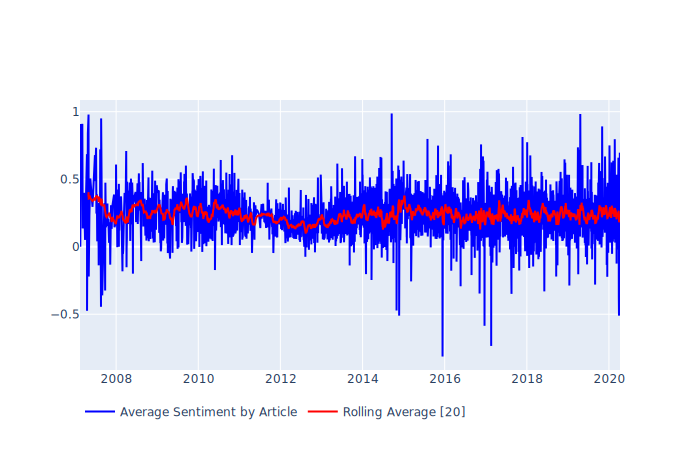

In [10]:
#Plot it
import plotly.graph_objects as go
import plotly.io as pio


rolling_mean = average_sent.Av_Score.rolling(window=20).mean()

pio.renderers
fig = go.Figure()
fig.add_trace(go.Scatter(x=average_sent.Date,y=average_sent.Av_Score,name='Average Sentiment by Article',
                       line=dict(color='blue')))
fig.add_trace(go.Scatter(x=average_sent.Date,y=rolling_mean,name='Rolling Average [20]',
                       line=dict(color='red')))
fig.update_layout(legend_orientation="h",
    autosize=True,
    width=2000,
    height=500,
)
fig.show(renderer="svg")

Looking at the top 10 most negative and positive articles by comments: (Note: I removed articles before 2008, as the variance in sentiment was pretty wild as there weren't many comments)

In [11]:
# Some of the most positive and negative articles:

average_sent = average_sent[average_sent.Date > '2008-01-01'].sort_values(by='Av_Score')

In [12]:
average_sent.head(10)

,Article,Av_Score,Date,Number_of_Comments
2567,"Juventus vs. Fiorentina, 2015 Serie A, Round 1...",-0.8131,2015-12-13 04:00:00,1
2712,Allegri: Juventus have a long way to go,-0.734967,2017-02-17 17:48:00,3
2835,Marotta optimistic ahead of Supercoppa,-0.5859,2016-12-20 12:07:00,1
4399,Report: Giorgio Chiellini signing a contract e...,-0.5106,2020-03-30 12:00:00,1
2000,Report: Juventus interested in signing Croatia...,-0.5106,2014-11-22 03:00:00,1
1953,Genoa 1-0 Juventus: Luca Antonini's last-gasp ...,-0.472463,2014-10-30 01:52:00,8
4397,"Juve, players reach agreement on salaries duri...",-0.372824,2020-03-28 22:52:00,17
4088,"Juventus’ Gianluigi Buffon, Paulo Dybala among...",-0.34925,2017-08-17 10:53:00,4
2865,Allegri relieved with Juventus win over Chievo,-0.3466,2016-11-06 08:54:00,3
3542,May’s Monthly Juventus Thoughts: Award Tour,-0.33085,2018-06-05 08:00:00,8


In [13]:
average_sent = average_sent.sort_values(by='Av_Score',ascending=False)

average_sent.head(10)

,Article,Av_Score,Date,Number_of_Comments
1927,Carlos Tévez ends goal drought to secure Juven...,0.98655,2014-09-16 22:00:00,2
4910,Allegri: Juventus won Scudetto despite constan...,0.9827,2019-04-21 05:05:00,1
4549,"Sarri still unclear about handball rules, does...",0.891,2019-11-01 16:34:00,1
3920,Landmarks of Turin Awards: Juventus vs Barcelo...,0.8126,2017-11-23 09:30:00,1
2400,Reports: Juventus set to extend Daniele Rugani...,0.798333,2015-08-01 03:01:00,3
4434,Sarri: Only perspective is on tomorrow’s match,0.7964,2020-02-21 19:59:00,1
3797,Allegri: Juventus took the right approach to t...,0.774,2018-01-03 18:00:00,1
2886,Allegri: Juve showed humility and great respect,0.7579,2016-11-19 15:07:00,1
4455,Sarri: Juventus working on eliminating errors,0.7504,2020-01-05 20:38:00,4
2535,Borussia Monchengladbach vs. Juventus: Champio...,0.74885,2015-11-03 03:00:00,2


Since most of the top articles only had a few comments, we redo our top 10 using only articles that have 10 or more comments

In [14]:
#Redone with only articles that have more than 10 comments
average_sent_adj = average_sent[average_sent.Number_of_Comments > 10]

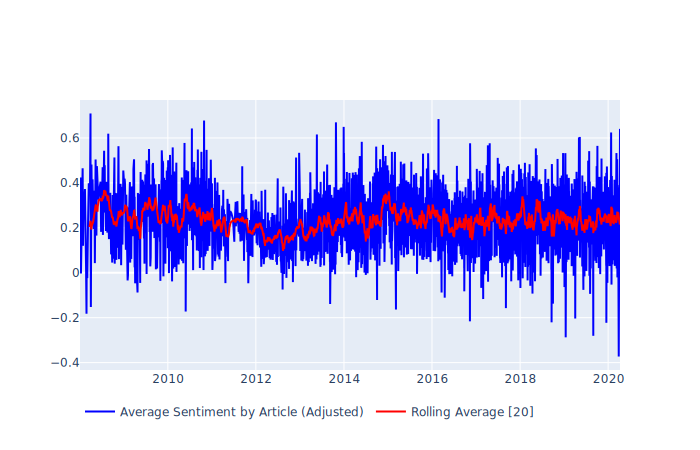

In [15]:
average_sent_adj = average_sent_adj.sort_values(by='Date')

rolling_mean = average_sent_adj.Av_Score.rolling(window=20).mean()

fig = go.Figure()
fig.add_trace(go.Scatter(x=average_sent_adj.Date,y=average_sent_adj.Av_Score,name='Average Sentiment by Article (Adjusted)',
                       line=dict(color='blue')))
fig.add_trace(go.Scatter(x=average_sent_adj.Date,y=rolling_mean,name='Rolling Average [20]',
                       line=dict(color='red')))
fig.update_layout(legend_orientation="h")
fig.show(renderer="svg")

In [16]:
average_sent_adj = average_sent_adj.sort_values(by='Av_Score')

average_sent_adj.head(10)

,Article,Av_Score,Date,Number_of_Comments
4397,"Juve, players reach agreement on salaries duri...",-0.372824,2020-03-28 22:52:00,17
5028,Boxing Day disaster in Serie A: Thoughts on It...,-0.287557,2019-01-13 23:06:00,54
4726,Martusciello preparing for Sarri return tomorrow,-0.280618,2019-08-30 20:21:00,11
4529,Juventus draw banged-up but dangerous Lyon for...,-0.222822,2019-12-17 04:00:00,137
5209,Douglas Costa suspended four games for Sassuol...,-0.22084,2018-09-18 23:00:00,57
2871,Croatia’s team doctor says Juventus were wrong...,-0.216307,2016-11-10 14:33:00,41
4879,Allegri: Racists should be identified and bann...,-0.203883,2019-04-03 03:00:00,75
74,Live Coverage: Derby della Mole,-0.1823,2008-02-26 10:54:00,20
495,Remembering Heysel- 25 Years On,-0.172719,2010-05-29 00:24:00,26
2128,Paul Pogba's chances of staying at Juventus? '...,-0.16363,2015-03-08 04:30:00,46


In [17]:
average_sent_adj = average_sent_adj.sort_values(by='Av_Score',ascending=False)

average_sent_adj.head(10)

,Article,Av_Score,Date,Number_of_Comments
81,An addition to the Juventus Offside...,0.708933,2008-03-30 17:22:00,12
3393,Allegri: Juventus can take courage from second...,0.684175,2016-02-24 00:23:00,12
646,PotD: More Of Your Artwork,0.67769,2010-10-28 14:38:00,21
1464,Juventus vs. Genoa Preview: Round 9 — Home is ...,0.6697,2013-10-26 09:00:00,12
1559,"Juventus Youth Update: Mid-season primavera, l...",0.649265,2013-12-29 13:22:00,23
553,One Static Striker Is Often Enough,0.64241,2010-07-19 13:47:00,41
4368,"Report: Rodrigo Bentancur, Merih Demiral deeme...",0.640517,2020-04-08 10:11:00,35
4487,Sarri: After Juventus I could retire,0.624335,2020-01-25 20:31:00,17
135,Serie A Offside Meet & Greet,0.619272,2008-08-24 22:04:00,79
1284,Chronicle of a Scudetto Foretold: Relive the r...,0.615627,2013-05-21 07:00:00,26


## Finding Players Mentioned in Comments

Since we've seen how the comment sentiment for each article and how it's relatively stable, can we track how the sentiment for individual players has changed over time?

To start, we create (and by create I mean stole) a function to extract the 'PERSON' or 'ORGANIZATION' from a comment. This is done by looking at the structure of a comment (explain this more) and by looking for capitalization.

In [19]:
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk import Tree

def get_continuous_chunks(text, label):
    chunked = ne_chunk(pos_tag(word_tokenize(text)))
    prev = None
    continuous_chunk = []
    current_chunk = []

    for subtree in chunked:
        if type(subtree) == Tree and subtree.label() == label:
            current_chunk.append(" ".join([token for token, pos in subtree.leaves()]))
        elif current_chunk:
            named_entity = " ".join(current_chunk)
            if named_entity not in continuous_chunk:
                continuous_chunk.append(named_entity)
                current_chunk = []
        else:
            continue

    return continuous_chunk

Looking at the first comment, we get an example of the people and organizations mentioned in it. Of note is how it can at times miss things based on the informal nature of blog comments.

In [20]:
test = comments.iloc[0,4]
test = test.replace('\r','').replace('\n',' ').replace('\p',' ')
ne_tree = ne_chunk(pos_tag(word_tokenize(test)))

print(test)
#print(ne_tree)
print(get_continuous_chunks(test, 'PERSON'))
print(get_continuous_chunks(test, 'ORGANIZATION'))

excellent, I thought all their games would be like this, a walk in the park. but I guess its a harder league then I thought it was. that second goal from Balzaretti was meant to be a cross (you dont need me telling you that) GREAT DEL PIERO!!
['Balzaretti']
['GREAT']


Now we just run this through all of the comments to look at who's mentioned the most in all comments.

In [ ]:
#Finds the frequerncy of names used in the comments
#I wouldn't run this, it takes forever

name_freq = pd.DataFrame([],columns = ['Name','Frequency'])

for i in range(0,len(names)):
    #Print to tell me where I am
    if (i / 1000 == i // 1000) | (i == len(names)):
        print(str(i)+' of '+str(len(names)))
    
    #Grab all the comments from an article. Make it one string, clean HTML elements
    temp_art = comments[comments.Article_Title == names[i]]
    temp_com = temp_art.Comment_Body.str.cat(sep='.')
    temp_com = temp_com.replace('\r','').replace('\n',' ').replace('\p',' ')
    
    #Find people and orginizations mentioned, put in one unique list
    pers = get_continuous_chunks(temp_com,'PERSON')
    org = get_continuous_chunks(temp_com,'ORGINIZATION')
    pers = pers + org
    pers = list(set(pers))
    
    #If people/orgs list isn't empty
    if (len(pers) != 0):
        for j in range(0,len(pers)):
            #see if the person already exists in my list
            temp2 = name_freq[name_freq.Name == pers[j]]
                
            if (temp2.empty):
                #if they don't exist, add them to the list, and the count of mentions
                temp2 = pd.DataFrame([pers[j],temp_com.count(pers[j])]).T
                temp2.columns = ['Name','Frequency']
                name_freq = name_freq.append(temp2)
            else:
                #if they do exist, add the count found in this comment section
                count = temp_com.count(pers[j])
                index = name_freq.index[name_freq.Name == pers[j]][0]
                name_freq.iloc[index,1] = name_freq.iloc[index,1] + count
        
        #reset the pandas indexing, becuase it's retarded
        name_freq = name_freq.reset_index(drop=True) 

Note: The previous code takes like 8 hours to run, so I just saved the results and load them up again to make things faster

In [21]:
#Load the data from the last loop to make it faster
name_freq = pd.read_csv('Data/Name_Freq.csv')

The top 30 most mentioned people/orginizations are as followed:

In [22]:
#Top 30 names
name_freq = name_freq.sort_values(by='Frequency',ascending=False)
name_freq.head(30)

,Name,Frequency
8,Juve,101949
35529,Dybala,26674
34,Juventus,24237
4365,Allegri,22388
34525,Pogba,19849
30,Marchisio,18175
1590,Conte,15112
962,Ronaldo,13863
16326,Pjanic,13227
6127,Bonucci,12552


A few things of note:

* Very few defenders made the list (Bonucci, Alex Sandro, and sorta Cuadrado)
* More surprising is that the only player who's been a member of Juve for the entire history of the blog (Chiellini) doesn't make the list
* At the opposite end a lot of strikers made the list (Dybala, Ronaldo, Higuain, Morata, Mandzukic), but few had any impact before the 2015/16 season (no love for Tevez)
* Every manager since 2011/12 made the list (Conte, Allegri, Sarri). Even though he hasn't finished a season yet, Sarri likely makes the list because of his time at Napoli
* Four time Serie A winner, human victory cigar, and club legend Stefano Sturaro doesn't make the list

## Looking at Sentiment for the Most Mentioned Players

From our list, we need to find comments that at some point mention our top 11 players by mentions in the comments (11 because I wanted to be sure to include Buffon and sexi boi Pirlo)

In [23]:
# Looking for top 11 players by mentions 
comments['Dybala'] = np.zeros(len(comments))
comments['Allegri'] = np.zeros(len(comments))
comments['Pogba'] = np.zeros(len(comments))

comments['Marchisio'] = np.zeros(len(comments))
comments['Conte'] = np.zeros(len(comments))
comments['Ronaldo'] = np.zeros(len(comments))

comments['Pjanic'] = np.zeros(len(comments))
comments['Bonucci'] = np.zeros(len(comments))
comments['Higuain'] = np.zeros(len(comments))

comments['Pirlo'] = np.zeros(len(comments))
comments['Buffon'] = np.zeros(len(comments))

In [25]:
#loop through all the comments
for i in range(0,len(comments)):
    
    if (i / 100000 == i // 100000) | (i == len(comments)-1):
        print(str(i)+' of '+str(len(comments)))
    
    #grab the comment, make it upper
    text = comments.iloc[i,4]
    if(type(text) != float):
        text = text.replace('\r','').replace('\n',' ').replace('\p',' ')
        text = text.upper()
    
        #find the number of mentions for each of the top 11
        num_dyb = text.count('DYBALA') + text.count(' JOYA ')
        num_alli = text.count('ALLEGRI')
        num_pog = text.count('POGBA')
        num_march = text.count('MARCHISIO') + text.count('CLAUDIO')
        num_conte = text.count('CONTE') + text.count('ANTONIO')
        num_CR = text.count('RONALDO ') + text.count('CRISTIANO ')
        num_pjan = text.count('PJANIC') + text.count(' MIRA ')
        num_bon = text.count('BONUCCI') + text.count('LEO ') + text.count('LEONARDO ')
        num_pork = text.count('HIGUAIN') + text.count('GONZALO')
        num_pirlo = text.count('PIRLO')
        num_buff = text.count('BUFFON') + text.count('GIGI')
    
        #save the number of mentions in the comment
        if (num_dyb != 0):
            comments.iloc[i,9] = num_dyb
        if (num_alli != 0):
            comments.iloc[i,10] = num_alli
        if (num_pog != 0):
            comments.iloc[i,11] = num_pog
        if (num_march != 0):
            comments.iloc[i,12] = num_march
        if (num_conte != 0):
            comments.iloc[i,13] = num_conte
        if (num_CR != 0):
            comments.iloc[i,14] = num_CR
        if (num_pjan != 0):
            comments.iloc[i,15] = num_pjan
        if (num_bon != 0):
            comments.iloc[i,16] = num_bon
        if (num_pork != 0):
            comments.iloc[i,17] = num_pork
        if (num_pirlo != 0):
            comments.iloc[i,18] = num_pirlo
        if (num_buff != 0):
            comments.iloc[i,19] = num_buff

0 of 630292
630291 of 630292


In [30]:
#Loading up the data from the loop so it doesn't have to run again
top_used = pd.read_csv('Data/Top_Names_Used.csv')

comments['Dybala'] = top_used['Dybala'].replace(0,"")
comments['Allegri'] = top_used['Allegri'].replace(0,"")
comments['Pogba'] = top_used['Pogba'].replace(0,"")
comments['Marchisio'] = top_used['Marchisio'].replace(0,"")
comments['Conte'] = top_used['Conte'].replace(0,"")
comments['Ronaldo'] = top_used['Ronaldo'].replace(0,"")
comments['Pjanic'] = top_used['Pjanic'].replace(0,"")
comments['Bonucci'] = top_used['Bonucci'].replace(0,"")
comments['Higuain'] = top_used['Higuain'].replace(0,"")
comments['Pirlo'] = top_used['Pirlo'].replace(0,"")
comments['Buffon'] = top_used['Buffon'].replace(0,"")

In [32]:
#Replace usage in comments with sentiment
for i in range(0,len(comments)):
    if (i / 100000 == i // 100000) | (i == len(comments)-1):
        print(str(i)+' of '+str(len(comments)))
        
    if ( (comments.iloc[i,9] != "") | (comments.iloc[i,10] != "") | (comments.iloc[i,11] != "") | (
        comments.iloc[i,12] != "") | (comments.iloc[i,13] != "") | (comments.iloc[i,14] != "") | (
        comments.iloc[i,15] != "") | (comments.iloc[i,16] != "") | (comments.iloc[i,17] != "") | (
        comments.iloc[i,18] != "") | (comments.iloc[i,19] != "") ):
        
        if(type(comments.iloc[i,4]) == float):
            comments.iloc[i,4] = ""
            
        score = sid.polarity_scores(comments.iloc[i,4])
        score = score['compound']
        
        if (comments.iloc[i,9] != ""):
            comments.iloc[i,9] = score
        if (comments.iloc[i,10] != ""):
            comments.iloc[i,10] = score
        if (comments.iloc[i,11] != ""):
            comments.iloc[i,11] = score
        if (comments.iloc[i,12] != ""):
            comments.iloc[i,12] = score
        if (comments.iloc[i,13] != ""):
            comments.iloc[i,13] = score
        if (comments.iloc[i,14] != ""):
            comments.iloc[i,14] = score
        if (comments.iloc[i,15] != ""):
            comments.iloc[i,15] = score
        if (comments.iloc[i,16] != ""):
            comments.iloc[i,16] = score
        if (comments.iloc[i,17] != ""):
            comments.iloc[i,17] = score
        if (comments.iloc[i,18] != ""):
            comments.iloc[i,18] = score
        if (comments.iloc[i,19] != ""):
            comments.iloc[i,19] = score

0 of 630292
100000 of 630292
200000 of 630292
300000 of 630292
400000 of 630292
500000 of 630292
600000 of 630292
630291 of 630292


In [34]:
dybala = comments[comments.Dybala != ""]
dybala = dybala[['Dybala','Comment_Date']]
allegri = comments[comments.Allegri != ""]
allegri = allegri[['Allegri','Comment_Date']]
pogba = comments[comments.Pogba != ""]
pogba = pogba[['Pogba','Comment_Date']]
marchisio = comments[comments.Marchisio != ""]
marchisio = marchisio[['Marchisio','Comment_Date']]
conte = comments[comments.Conte != ""]
conte = conte[['Conte','Comment_Date']]
ronaldo = comments[comments.Ronaldo != ""]
ronaldo = ronaldo[['Ronaldo','Comment_Date']]
pjanic = comments[comments.Pjanic != ""]
pjanic = pjanic[['Pjanic','Comment_Date']]
bonucci = comments[comments.Bonucci != ""]
bonucci = bonucci[['Bonucci','Comment_Date']]
higuain = comments[comments.Higuain != ""]
higuain = higuain[['Higuain','Comment_Date']]
pirlo = comments[comments.Pirlo != ""]
pirlo = pirlo[['Pirlo','Comment_Date']]
buffon = comments[comments.Buffon != ""]
buffon = buffon[['Buffon','Comment_Date']]

In [48]:
dybala['Comment_Date'] = pd.to_datetime(dybala.Comment_Date)
dybala = dybala.sort_values(by='Comment_Date')
dybala['Average'] = dybala.Dybala.rolling(window=20).mean()

allegri['Comment_Date'] = pd.to_datetime(allegri.Comment_Date)
allegri = allegri.sort_values(by='Comment_Date')
allegri['Average'] = allegri.Allegri.rolling(window=20).mean()

pogba['Comment_Date'] = pd.to_datetime(pogba.Comment_Date)
pogba = pogba.sort_values(by='Comment_Date')
pogba['Average'] = pogba.Pogba.rolling(window=20).mean()

marchisio['Comment_Date'] = pd.to_datetime(marchisio.Comment_Date)
marchisio = marchisio.sort_values(by='Comment_Date')
marchisio['Average'] = marchisio.Marchisio.rolling(window=20).mean()

conte['Comment_Date'] = pd.to_datetime(conte.Comment_Date)
conte = conte.sort_values(by='Comment_Date')
conte['Average'] = conte.Conte.rolling(window=20).mean()

ronaldo['Comment_Date'] = pd.to_datetime(ronaldo.Comment_Date)
ronaldo = ronaldo.sort_values(by='Comment_Date')
ronaldo['Average'] = ronaldo.Ronaldo.rolling(window=20).mean()

In [50]:
pjanic['Comment_Date'] = pd.to_datetime(pjanic.Comment_Date)
pjanic = pjanic.sort_values(by='Comment_Date')
pjanic['Average'] = pjanic.Pjanic.rolling(window=20).mean()

bonucci['Comment_Date'] = pd.to_datetime(bonucci.Comment_Date)
bonucci = bonucci.sort_values(by='Comment_Date')
bonucci['Average'] = bonucci.Bonucci.rolling(window=20).mean()

higuain['Comment_Date'] = pd.to_datetime(higuain.Comment_Date)
higuain = higuain.sort_values(by='Comment_Date')
higuain['Average'] = higuain.Higuain.rolling(window=20).mean()

pirlo['Comment_Date'] = pd.to_datetime(pirlo.Comment_Date)
pirlo = pirlo.sort_values(by='Comment_Date')
pirlo['Average'] = pirlo.Pirlo.rolling(window=20).mean()

buffon['Comment_Date'] = pd.to_datetime(buffon.Comment_Date)
buffon = buffon.sort_values(by='Comment_Date')
buffon['Average'] = buffon.Buffon.rolling(window=20).mean()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



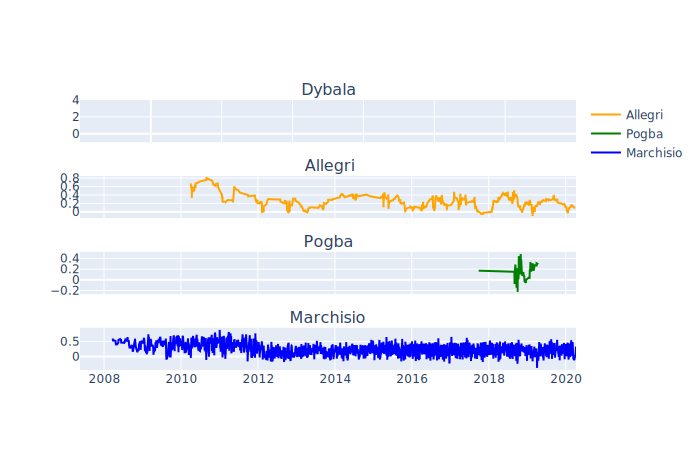

In [62]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=4, cols=1,
                   shared_xaxes=True, 
                   subplot_titles=("Dybala", "Allegri", "Pogba", "Marchisio"))
fig.append_trace(go.Scatter(x=dybala.Comment_Date,y=dybala.Average,name='Dybala',
                       line=dict(color='red')), row=1, col=1)
fig.append_trace(go.Scatter(x=allegri.Comment_Date,y=allegri.Average,name='Allegri',
                       line=dict(color='orange')), row=2, col=1)
fig.append_trace(go.Scatter(x=pogba.Comment_Date,y=pogba.Average,name='Pogba',
                       line=dict(color='green')), row=3, col=1)
fig.append_trace(go.Scatter(x=marchisio.Comment_Date,y=marchisio.Average,name='Marchisio',
                       line=dict(color='blue')), row=4, col=1)
fig.show(renderer="svg")

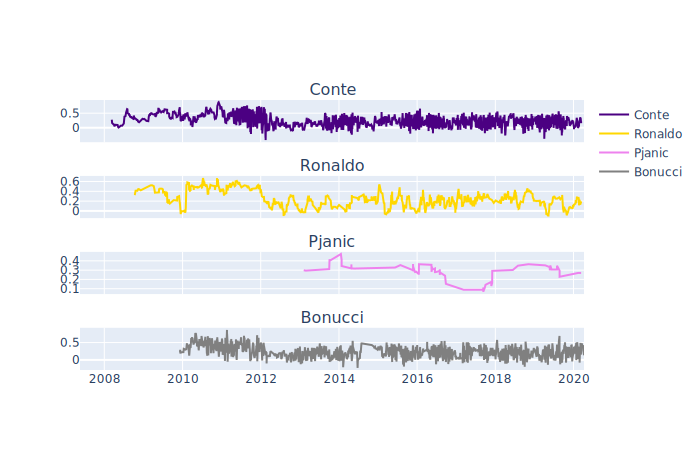

In [63]:
fig = make_subplots(rows=4, cols=1,
                   shared_xaxes=True, 
                   subplot_titles=("Conte","Ronaldo","Pjanic","Bonucci"))
fig.append_trace(go.Scatter(x=conte.Comment_Date,y=conte.Average,name='Conte',
                       line=dict(color='indigo')), row=1, col=1)
fig.append_trace(go.Scatter(x=ronaldo.Comment_Date,y=ronaldo.Average,name='Ronaldo',
                       line=dict(color='gold')), row=2, col=1)
fig.append_trace(go.Scatter(x=pjanic.Comment_Date,y=pjanic.Average,name='Pjanic',
                       line=dict(color='violet')), row=3, col=1)
fig.append_trace(go.Scatter(x=bonucci.Comment_Date,y=bonucci.Average,name='Bonucci',
                       line=dict(color='grey')), row=4, col=1)
fig.show(renderer="svg")

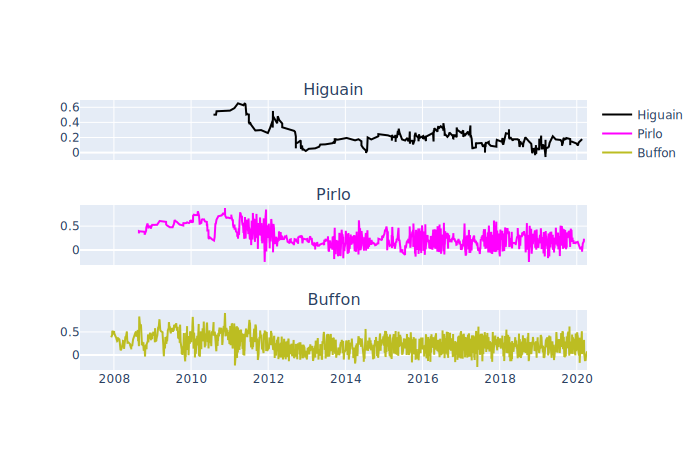

In [64]:
fig = make_subplots(rows=3, cols=1,
                   shared_xaxes=True, 
                   subplot_titles=("Higuain","Pirlo","Buffon"))
fig.append_trace(go.Scatter(x=higuain.Comment_Date,y=higuain.Average,name='Higuain',
                       line=dict(color='black')), row=1, col=1)
fig.append_trace(go.Scatter(x=pirlo.Comment_Date,y=pirlo.Average,name='Pirlo',
                       line=dict(color='magenta')), row=2, col=1)
fig.append_trace(go.Scatter(x=buffon.Comment_Date,y=buffon.Average,name='Buffon',
                       line=dict(color='#bcbd22')), row=3, col=1)
fig.show(renderer="svg")

In [68]:
pogba.head(50)

,Pogba,Comment_Date,Average
92927,0.4137,2012-01-24,NaN
97821,0.5423,2012-02-10,NaN
96487,-0.3612,2012-02-23,NaN
96488,0.7506,2012-02-23,NaN
92927,-0.6504,2014-05-18,NaN
96487,0.4601,2014-06-14,NaN
96488,0.3724,2014-06-14,NaN
97821,0,2014-07-25,NaN
96488,0.1942,2016-04-09,NaN
96487,-0.8095,2016-04-09,NaN
